1. Activate the virtual environment: 
source /Users/sofiamorenolasa/Desktop/TFG/.venv/bin/activate
2. Switch to the virtual environment

In [17]:
import pandas as pd

file_path = "../data/PARAMETROS_TJ2.csv"

# Use latin1 encoding
data = pd.read_csv(file_path, delimiter=";", encoding="latin1")

# Display the first few rows
print(data.head())

   N_DESCARGA       fecha   hora comentarioDesc comentarioExp configuracion  \
0         112  19971217.0  19:05            NaN           NaN           NaN   
1         113  19971217.0  19:09            NaN           NaN           NaN   
2         114  19971217.0  19:55            NaN           NaN           NaN   
3         115  19971218.0  11:08            NaN           NaN           NaN   
4         116  19971218.0  11:28            NaN           NaN           NaN   

   potencia_radiada  energia_diamagnetica  retraso_densidad_girotron  zeff  \
0               NaN                   NaN                        NaN   NaN   
1               NaN                   NaN                        NaN   NaN   
2               NaN                   NaN                        NaN   NaN   
3               NaN                   NaN                        NaN   NaN   
4               NaN                   NaN                        NaN   NaN   

   ...  IAccel_nominal_NBI2  tini_NBI2  longitud_pulso_n

/var/folders/b6/pb_stfjn0pb7pybgwlqjk5700000gn/T/ipykernel_87239/2676448733.py:6: DtypeWarning: Columns (52,55,96,132,133,144,145) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, delimiter=";", encoding="latin1")


Next, we sort the PARAMETROS_TJ2.csv file by the N_DESCARGA field and save the sorted data to a new file named PARAMETROS_TJ2_ORDENADOS.csv. This ensures the rows are ordered starting from the smallest N_DESCARGA value to the largest.

In [14]:
import pandas as pd

# Load the dataset
input_file_path = "../data/PARAMETROS_TJ2.csv"  # Replace with the correct path
output_file_path = "../data/PARAMETROS_TJ2_ORDENADOS.csv"

# Read the data
data = pd.read_csv(input_file_path, delimiter=";", encoding="latin1")

# Convert N_DESCARGA to numeric, coercing errors to NaN
data['N_DESCARGA'] = pd.to_numeric(data['N_DESCARGA'], errors='coerce')

# Drop rows where N_DESCARGA is NaN (invalid values)
data = data.dropna(subset=['N_DESCARGA'])

# Ensure N_DESCARGA is an integer
data['N_DESCARGA'] = data['N_DESCARGA'].astype(int)

# Sort by N_DESCARGA in ascending order
data_sorted = data.sort_values(by='N_DESCARGA')

# Save the sorted dataset to a new CSV file
data_sorted.to_csv(output_file_path, index=False, sep=";", encoding="latin1")

print(f"Sorted data saved to {output_file_path}")

/var/folders/b6/pb_stfjn0pb7pybgwlqjk5700000gn/T/ipykernel_87239/1307042932.py:8: DtypeWarning: Columns (52,55,96,132,133,144,145) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(input_file_path, delimiter=";", encoding="latin1")


Sorted data saved to ../data/PARAMETROS_TJ2_ORDENADOS.csv


Next, we will convert this .csv file to a .txt to help with training with a RAG system

MODIFY THE TEXT BELOW TO INCLUDE ONLY THE IMPORTANT FIELDS.

In [24]:
import os
import pandas as pd
import re

def process_csv_to_txt(csv_path, txt_path):
    """
    Processes a CSV file with semicolon delimiters, extracts and cleans relevant data,
    and saves it as a .txt file.

    Args:
        csv_path (str): Path to the input CSV file.
        txt_path (str): Path to save the output .txt file.
    """
    try:
        # Read the CSV file with semicolon as the delimiter
        data = pd.read_csv(csv_path, delimiter=';', encoding='latin1', on_bad_lines='skip')
    except Exception as e:
        print(f"Error reading {csv_path}: {e}")
        return

    # Initialize the text content
    text = ''

    # Iterate over the rows of the CSV
    for index, row in data.iterrows():
        # Extract the necessary fields (customize this based on your analysis needs)
        descarga = row.get('N_DESCARGA', 'N/A')
        fecha = row.get('fecha', 'N/A')
        comentario = row.get('comentarioDesc', 'N/A')
        configuracion = row.get('configuracion', 'N/A')
        energia_diamagnetica = row.get('energia_diamagnetica', 'N/A')

        # Format the extracted data into a readable string
        text += (
            f"Descarga: {descarga}\n"
            f"Fecha: {fecha}\n"
            f"Comentario: {comentario}\n"
            f"Configuración: {configuracion}\n"
            f"Energía Diamagnética: {energia_diamagnetica}\n"
            f"{'-'*40}\n"  # Separator for readability
        )

    # Save the processed text to the output file
    try:
        with open(txt_path, 'w', encoding='utf-8') as txt_file:
            txt_file.write(text)
        print(f"Processed data saved to {txt_path}")
    except Exception as e:
        print(f"Error saving to {txt_path}: {e}")


# Input and output paths
csv_path = "../data/PARAMETROS_TJ2_ORDENADOS.csv"
txt_folder = "../data/txt_output/"

# Ensure the output folder exists
os.makedirs(txt_folder, exist_ok=True)

# Generate the output .txt file name
txt_path = os.path.join(txt_folder, "PARAMETROS_TJ2_ORDENADOS.txt")

# Process the CSV and save it as a .txt file
process_csv_to_txt(csv_path, txt_path)

/var/folders/b6/pb_stfjn0pb7pybgwlqjk5700000gn/T/ipykernel_87239/1245340582.py:16: DtypeWarning: Columns (52,54,55,96,105,108,110,122,125,129,132,133,137,138,143,144,145,150,151,154) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(csv_path, delimiter=';', encoding='latin1', on_bad_lines='skip')


Processed data saved to ../data/txt_output/PARAMETROS_TJ2_ORDENADOS.txt


Hay que borrar los datos repetidos, hay muchos donde la hora y la fecha son iguales, aunque el numero de descarga sea diferente, así que habría que dejar solo uno. 

Ahora hay que crear una base de datos vectorial a partir de los archivos .txt (database_creator)

the code is using a GPU if one is available, and it’s enabled by the SentenceTransformer library

TRY THIS IN GOOGLE COLAB TO CREATE THE VECTOR_DATABASE

# Step 2: Import Libraries
import json
import os
import faiss
from sentence_transformers import SentenceTransformer

# Ensure CUDA configuration for PyTorch
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Step 3: Define Helper Functions
# Load and split the text file into paragraphs
def load_and_split_text(file_path, context_size=0):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    # Split the text into paragraphs based on double line breaks
    split_paragraphs = [para.strip() for para in text.split('\n\n') if para.strip()]

    paragraphs = []
    for para in split_paragraphs:
        # Handle missing or invalid values
        para = para.replace("nan", "N/A")  # Replace 'nan' with a placeholder
        paragraphs.append(para)

    # Add context if needed
    if context_size > 0:
        paragraphs_with_context = []
        for i, para in enumerate(paragraphs):
            previous_context = paragraphs[i - 1][-context_size:] if i > 0 else ""
            next_context = paragraphs[i + 1][:context_size] if i < len(paragraphs) - 1 else ""
            combined_para = f"{previous_context} {para} {next_context}"
            paragraphs_with_context.append(combined_para)
        return paragraphs_with_context

    return paragraphs


# Generate embeddings for the paragraphs
def generate_embeddings(paragraphs, model_name):
    model = SentenceTransformer(model_name, device='cuda')
    metadata = []

    for i, para in enumerate(paragraphs):
        metadata.append({
            "id": i,
            "paragraph": para,
        })
    embeddings = model.encode(paragraphs, convert_to_numpy=True)
    return embeddings, metadata


# Build a FAISS index
def build_faiss_index(embeddings):
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)
    return index


# Main processing for the nuclear fusion project
def process_nuclear_fusion_data(txt_path, model_name, context_sizes, database_base_path):
    for context_size in context_sizes:
        database_path = os.path.join(database_base_path, f"{model_name}_{context_size}")

        index_path = os.path.join(database_path, "db.index")
        metadata_path = os.path.join(database_path, "metadata.json")

        print(f"Processing with context size {context_size}...")

        # Load and split the text
        print("Loading and splitting text...")
        paragraphs = load_and_split_text(txt_path, context_size=context_size)

        # Generate embeddings
        print("Generating embeddings...")
        embeddings, metadata = generate_embeddings(paragraphs, model_name=model_name)

        # Build FAISS index
        print("Building FAISS index...")
        index = build_faiss_index(embeddings)

        # Save the database
        print(f"Saving the database to {database_path}...")
        if not os.path.exists(database_path):
            os.makedirs(database_path, exist_ok=True)
        faiss.write_index(index, index_path)

        # Save the metadata as a JSON file
        with open(metadata_path, "w", encoding="utf-8") as f:
            json.dump(metadata, f, ensure_ascii=False, indent=4)

    print("Database creation complete.")

# Step 4: Paths and Configurations
TXT_FILE_PATH = "/content/PARAMETROS_TJ2_ORDENADOS.txt"  # Absolute path to your file
MODEL_NAME = "allenai/scibert_scivocab_uncased"  # Use a suitable pre-trained model
CONTEXT_SIZES = [0, 25, 50, 75, 100]  # Adjust context sizes as needed
DATABASE_BASE_PATH = "./vector_database"  # Local path in Colab environment

# Step 5: Process the Text File and Create the Vectorial Database
process_nuclear_fusion_data(TXT_FILE_PATH, MODEL_NAME, CONTEXT_SIZES, DATABASE_BASE_PATH)

# Step 6: Download Output Files
# Zip the output folder for download
!zip -r vector_database.zip ./vector_database

# Provide a link to download
from google.colab import files
files.download('vector_database.zip')

In [ ]:
import csv
import json
from collections import OrderedDict

# Path to the input CSV file
csv_file_path = "data/PARAMETROS_TJ2_model.csv"
# Path to the output JSON file
json_file_path = "data/PARAMETROS_TJ2_model.json"

# Open and process the CSV file
with open(csv_file_path, mode='r', encoding='utf-8') as csv_file:
    csv_reader = csv.DictReader(csv_file, delimiter=';')  # Adjust delimiter based on your file
    data = []

    # Read each row and convert to OrderedDict to maintain order
    for row in csv_reader:
        ordered_row = OrderedDict(row)
        data.append(ordered_row)

# Write the data to a JSON file
with open(json_file_path, mode='w', encoding='utf-8') as json_file:
    json.dump(data, json_file, ensure_ascii=False, indent=4)

print(f"CSV has been successfully converted to JSON and saved to {json_file_path}")

CSV has been successfully converted to JSON and saved to data/PelletInjections_AP.json


write a script so that it goes through the json file, and so that if the value is empty, it deletes it. e.g., here it should detele this: 

In [3]:
import json

# Path to the input JSON file
json_file_path = "data/PARAMETROS_TJ2_model.json"
# Path to the output cleaned JSON file
cleaned_json_file_path = "data/PARAMETROS_TJ2_model_cleaned.json"

# Open and load the JSON file
with open(json_file_path, mode='r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# Function to clean empty values from a dictionary
def clean_empty_values(item):
    if isinstance(item, dict):
        return {k: clean_empty_values(v) for k, v in item.items() if v not in [None, "", []]}
    elif isinstance(item, list):
        return [clean_empty_values(i) for i in item if i not in [None, "", []]]
    else:
        return item

# Clean the data
cleaned_data = clean_empty_values(data)

# Save the cleaned data back to a JSON file
with open(cleaned_json_file_path, mode='w', encoding='utf-8') as cleaned_json_file:
    json.dump(cleaned_data, cleaned_json_file, ensure_ascii=False, indent=4)

print(f"Cleaned JSON has been saved to {cleaned_json_file_path}")

Cleaned JSON has been saved to data/PARAMETROS_TJ2_model_cleaned.json


In [ ]:
import json

# Path to the input JSON file
json_file_path = "../data/PARAMETROS_TJ2_model_cleaned.json"

# List of keys to check
keys_to_check = [
    "valvula_li1", "valvula_li2", "valvula_he", "valvula_cx1", "valvula_cx2", 
    "valvula_nb", "valvula_cnb1", "valvula_cnb2", 
    "polaridad_limitador_a3bot", "polaridad_limitador_c3bot", "polaridad_electrodo_a7top"
]

# Open and load the JSON file
with open(json_file_path, mode='r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# Find N_DESCARGA values where any of the keys have a value not equal to 0
n_descarga_values = [
    item["N_DESCARGA"] for item in data
    if any(key in item and item[key] not in ["0", 0, None] for key in keys_to_check)
]

# Output the results
print("N_DESCARGA values where any specified key is not 0:")
print(n_descarga_values)

N_DESCARGA values where any specified key is not 0:
['8520', '8521', '8523', '8524', '8525', '8526', '8527', '8528', '8529', '8530', '8531', '8532', '8533', '8534', '8536', '8537', '8538', '8539', '8540', '8541', '8542', '8543', '8544', '8545', '8546', '8547', '8548', '8549', '8550', '8551', '8552', '8553', '8554', '8555', '8556', '8557', '8558', '8559', '8560', '8561', '8562', '8672', '8673', '8674', '8675', '8676', '8677', '8678', '8679', '8688', '8689', '8717', '8718', '8719', '8720', '8721', '9414', '9422', '9423', '9424', '9426', '9427', '9428', '9429', '9430', '9431', '9432', '9433', '9434', '9435', '9436', '9437', '9438', '9439', '9440', '9441', '9442', '9443', '9444', '9445', '9446', '9447', '9448', '9620', '9621', '9622', '9623', '9624', '9833', '9834', '9835', '9836', '9837', '9888', '9889', '9891', '9892', '9893', '9894', '9895', '9898', '9899', '9900', '9901', '9902', '9903', '9904', '9905', '9906', '9907', '9908', '9909', '11669', '11670', '11671', '11672', '14000', '14001

Replace all valvula_* keys with a single valvula = 0 and all polaridad_* keys with polaridad = 0 in the JSON file. This simplifies the structure and reduces redundancy.

In [4]:
import json

# Path to the input JSON file
json_file_path = "data/PARAMETROS_TJ2_model_cleaned.json"
# Path to the output JSON file
output_json_file_path = "data/PARAMETROS_TJ2_model_reduced.json"

# Lists of keys to consolidate
valvula_keys = [
    "valvula_li1", "valvula_li2", "valvula_he", "valvula_cx1", "valvula_cx2",
    "valvula_nb", "valvula_cnb1", "valvula_cnb2"
]
polaridad_keys = [
    "polaridad_limitador_a3bot", "polaridad_limitador_c3bot", "polaridad_electrodo_a7top"
]

# Open and load the JSON file
with open(json_file_path, mode='r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# Update each item in the JSON data
for item in data:
    # Replace all valvula_* keys with valvula = 0
    if all(item.get(key) in ["0", 0, None] for key in valvula_keys):
        # Remove individual valvula_* keys
        for key in valvula_keys:
            item.pop(key, None)
        # Add consolidated valvula = 0
        item["valvula"] = "0"

    # Replace all polaridad_* keys with polaridad = 0
    if all(item.get(key) in ["0", 0, None] for key in polaridad_keys):
        # Remove individual polaridad_* keys
        for key in polaridad_keys:
            item.pop(key, None)
        # Add consolidated polaridad = 0
        item["polaridad"] = "0"

# Save the updated JSON data to a new file
with open(output_json_file_path, mode='w', encoding='utf-8') as output_json_file:
    json.dump(data, output_json_file, ensure_ascii=False, indent=4)

print(f"Reduced JSON has been saved to {output_json_file_path}")

Reduced JSON has been saved to data/PARAMETROS_TJ2_model_reduced.json


In [ ]:
import json
import unicodedata

# Function to clean text
def clean_text(text):
    # Normalize text to handle special characters
    normalized = unicodedata.normalize('NFKD', text)
    # Encode to ASCII, ignoring errors, and decode back to UTF-8
    cleaned = normalized.encode('ascii', 'ignore').decode('utf-8')
    return cleaned

# Path to your JSON file
file_path = "/Users/sofiamorenolasa/Desktop/TFG/Anomaly detection/data/PARAMETROS_TJ2_model_reduced.json"

# Load the JSON data
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Clean the `comentarioExp` field in all records
for record in data:
    if 'comentarioExp' in record and isinstance(record['comentarioExp'], str):
        record['comentarioExp'] = clean_text(record['comentarioExp'])

# Save the cleaned data back to the file
output_path = "/Users/sofiamorenolasa/Desktop/TFG/Anomaly detection/data/PARAMETROS_TJ2_model_cleaned.json"
with open(output_path, 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4, ensure_ascii=False)

print(f"Cleaned data saved to {output_path}")

We will clean both comentarioExp and comentarioDesc fields in your JSON file to avoid the �

In [5]:
import json
import re

# Path to the input and output JSON files
input_file_path = "data/PARAMETROS_TJ2_model_reduced.json"
output_file_path = "data/PARAMETROS_TJ2_model_clean.json"

def remove_corrupted_symbols(text):
    """
    Remove all instances of the corrupted symbol '�' from the text.
    """
    return text.replace("�", "")

# Load the JSON data
with open(input_file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Remove corrupted symbols from relevant fields
for record in data:
    for field in ['comentarioExp', 'comentarioDesc', 'pared']:
        if field in record and isinstance(record[field], str):
            record[field] = remove_corrupted_symbols(record[field])

# Save the cleaned data back to a new JSON file
with open(output_file_path, 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4, ensure_ascii=False)

print(f"Cleaned JSON file saved to: {output_file_path}")

Cleaned JSON file saved to: data/PARAMETROS_TJ2_model_clean.json


In [6]:
import json
import re

# Load column names from file
def load_column_names(file_path="data/column_names.txt"):
    with open(file_path, "r") as file:
        return [line.strip() for line in file.readlines()]

# Load parameter data from JSON file
def load_json_data(file_path="data/PARAMETROS_TJ2_model_reduced.json"):
    with open(file_path, "r") as file:
        return json.load(file)

# Extract the keyword from the user query (e.g., "ECRH1" from "What is the max value of ECRH1?")
def extract_keyword(query, column_names):
    words = query.split()
    
    # Check if any word in the query is inside column names
    for word in words:
        matches = [col for col in column_names if word.lower() in col.lower()]
        if matches:
            return word  # Return the first valid keyword found
    
    return None  # No match found

# Retrieve relevant keys based on query keyword
def retrieve_relevant_keys(keyword, column_names):
    return [key for key in column_names if keyword.lower() in key.lower()]

# Process user query
def process_query(query):
    column_names = load_column_names()
    
    keyword = extract_keyword(query, column_names)
    if not keyword:
        return "No matching parameters found."

    relevant_keys = retrieve_relevant_keys(keyword, column_names)

    if len(relevant_keys) == 0:
        return "No matching parameters found."

    return relevant_keys  # Return all matching column names

# Example usage
query = input("Enter your query: ")  # Example: "What is the max value of ECRH1?"
result = process_query(query)
print(result)  # Expected output: ['angulo_1_ECRH1', 'angulo_2_ECRH1']

['inyeccion_OnOff_axis_ECRH1', 'inyeccion_OnOff_axis_ECRH2']


In [10]:
import json
import re

# File paths
COLUMN_NAMES_FILE = "data/column_names.txt"
PARAMETERS_FILE = "data/PARAMETROS_TJ2_model_reduced.json"

# Load column names from file
def load_column_names(file_path=COLUMN_NAMES_FILE):
    with open(file_path, "r") as file:
        column_names = [line.strip() for line in file.readlines()]
    print("\n[DEBUG] Loaded column names:", column_names)  # Debugging step
    return column_names

# Load parameter data from JSON file
def load_json_data(file_path=PARAMETERS_FILE):
    with open(file_path, "r") as file:
        return json.load(file)

# Extract the best keyword from the user query
def extract_keyword(query, column_names):
    # Clean up query (remove punctuation, lowercase)
    query_cleaned = re.sub(r'[^a-zA-Z0-9_ ]', '', query).lower()
    words = query_cleaned.split()
    
    # Ignore common words
    ignored_words = {"what", "is", "the", "max", "value", "of", "minimum", "mean"}
    keywords = [word for word in words if word not in ignored_words]

    print("\n[DEBUG] Possible keywords:", keywords)

    # Find the most relevant keyword (longest match in column names)
    for keyword in keywords:
        exact_matches = [col for col in column_names if keyword.lower() == col.lower()]
        if exact_matches:
            print(f"[DEBUG] Exact match found: {keyword}")
            return keyword  # Return exact match if found

    for keyword in keywords:
        partial_matches = [col for col in column_names if keyword.lower() in col.lower()]
        if partial_matches:
            print(f"[DEBUG] Partial match found: {keyword}")
            return keyword  # Return the first valid keyword found

    print("[DEBUG] No keyword extracted.")
    return None  # No match found

# Retrieve relevant keys based on an exact keyword match
def retrieve_relevant_keys(keyword, column_names):
    matches = [key for key in column_names if re.search(rf"\b{re.escape(keyword)}\b", key, re.IGNORECASE)]
    print(f"\n[DEBUG] Matching keys for '{keyword}':", matches)  # Debugging
    return matches

# Process user query
def process_query(query):
    column_names = load_column_names()
    
    keyword = extract_keyword(query, column_names)
    if not keyword:
        return "No matching parameters found."

    relevant_keys = retrieve_relevant_keys(keyword, column_names)

    if len(relevant_keys) == 0:
        return "No matching parameters found."

    return relevant_keys  # Return all matching column names

# Example query
query = "What is the max value of ECRH1?"
result = process_query(query)
print("\n[FINAL RESULT]:", result)  # Expected: Only parameters containing "ECRH1"


[DEBUG] Loaded column names: ['IAccel_nominal_NBI1', 'IAccel_nominal_NBI2', 'IAccel_real_NBI1', 'IAccel_real_NBI2', 'N_DESCARGA', 'VAccel_nominal_NBI1', 'VAccel_nominal_NBI2', 'VAccel_real_NBI1', 'VAccel_real_NBI2', 'angulo_1_ECRH1', 'angulo_1_ECRH2', 'angulo_2_ECRH1', 'angulo_2_ECRH2', 'angulo_DR', 'angulo_polarizacion_eliptica_ECRH1', 'angulo_polarizacion_lineal_ECRH1', 'angulo_polarizacion_lineal_ECRH2', 'angulo_toroidal_deposicion_ECRH1', 'angulo_toroidal_deposicion_ECRH2', 'comentarioDesc', 'comentarioExp', 'configuracion', 'factor_transm_NBI1', 'factor_transm_NBI2', 'fecha', 'fmod_ECRH1', 'fmod_ECRH2', 'hora', 'hx', 'icc', 'inyeccion_OnOff_axis_ECRH1', 'inyeccion_OnOff_axis_ECRH2', 'itf', 'limitador_z1', 'limitador_z2', 'longitud_pulso_nominal_ECRH1', 'longitud_pulso_nominal_ECRH2', 'longitud_pulso_nominal_NBI1', 'longitud_pulso_nominal_NBI2', 'longitud_pulso_real_ECRH1', 'longitud_pulso_real_ECRH2', 'longitud_pulso_real_NBI1', 'longitud_pulso_real_NBI2', 'modulacion_ECRH1', 'mo

NLP TO GET THE SAME COLUMN NAMES

Why This Works Better

✅ Uses NLP (spaCy) to intelligently extract technical terms (like "ECRH1") from the query.

✅ Ensures "ECRH1" doesn’t mistakenly match "ECRH2".

✅ Handles plural words, variations, and synonyms more robustly.

In [13]:
import json
import spacy

# File paths
COLUMN_NAMES_FILE = "data/column_names.txt"
PARAMETERS_FILE = "data/PARAMETROS_TJ2_model_reduced.json"

# Load spaCy NLP model
nlp = spacy.load("en_core_web_sm")

# Load column names from file
def load_column_names(file_path=COLUMN_NAMES_FILE):
    with open(file_path, "r") as file:
        column_names = [line.strip() for line in file.readlines()]
    print("\n[DEBUG] Loaded column names:", column_names)  # Debugging step
    return column_names

# Load parameter data from JSON file
def load_json_data(file_path=PARAMETERS_FILE):
    with open(file_path, "r") as file:
        return json.load(file)

# Extract the best keyword from the user query using NLP
def extract_keyword(query, column_names):
    doc = nlp(query)  # Process query with spaCy

    # Extract nouns, proper nouns, or words with numbers (e.g., "ECRH1")
    keywords = [token.text for token in doc if token.pos_ in {"NOUN", "PROPN"} or any(char.isdigit() for char in token.text)]
    
    print("\n[DEBUG] NLP Extracted Keywords:", keywords)

    # Find the best match in column names
    for keyword in keywords:
        exact_matches = [col for col in column_names if keyword.lower() == col.lower()]
        if exact_matches:
            print(f"[DEBUG] Exact match found: {keyword}")
            return keyword  # Return exact match if found

    for keyword in keywords:
        partial_matches = [col for col in column_names if keyword.lower() in col.lower()]
        if partial_matches:
            print(f"[DEBUG] Partial match found: {keyword}")
            return keyword  # Return first valid keyword found

    print("[DEBUG] No keyword extracted.")
    return None  # No match found

# Retrieve relevant keys based on an exact keyword match
def retrieve_relevant_keys(keyword, column_names):
    matches = [key for key in column_names if keyword.lower() in key.lower()]
    print(f"\n[DEBUG] Matching keys for '{keyword}':", matches)  # Debugging
    return matches

# Process user query
def process_query(query):
    column_names = load_column_names()
    
    keyword = extract_keyword(query, column_names)
    if not keyword:
        return "No matching parameters found."

    relevant_keys = retrieve_relevant_keys(keyword, column_names)

    if len(relevant_keys) == 0:
        return "No matching parameters found."

    return relevant_keys  # Return all matching column names

# Example query
query = "What is the max value of descarga?"
result = process_query(query)
print("\n[FINAL RESULT]:", result)  # Expected: Only parameters containing "ECRH1"


[DEBUG] Loaded column names: ['IAccel_nominal_NBI1', 'IAccel_nominal_NBI2', 'IAccel_real_NBI1', 'IAccel_real_NBI2', 'N_DESCARGA', 'VAccel_nominal_NBI1', 'VAccel_nominal_NBI2', 'VAccel_real_NBI1', 'VAccel_real_NBI2', 'angulo_1_ECRH1', 'angulo_1_ECRH2', 'angulo_2_ECRH1', 'angulo_2_ECRH2', 'angulo_DR', 'angulo_polarizacion_eliptica_ECRH1', 'angulo_polarizacion_lineal_ECRH1', 'angulo_polarizacion_lineal_ECRH2', 'angulo_toroidal_deposicion_ECRH1', 'angulo_toroidal_deposicion_ECRH2', 'comentarioDesc', 'comentarioExp', 'configuracion', 'factor_transm_NBI1', 'factor_transm_NBI2', 'fecha', 'fmod_ECRH1', 'fmod_ECRH2', 'hora', 'hx', 'icc', 'inyeccion_OnOff_axis_ECRH1', 'inyeccion_OnOff_axis_ECRH2', 'itf', 'limitador_z1', 'limitador_z2', 'longitud_pulso_nominal_ECRH1', 'longitud_pulso_nominal_ECRH2', 'longitud_pulso_nominal_NBI1', 'longitud_pulso_nominal_NBI2', 'longitud_pulso_real_ECRH1', 'longitud_pulso_real_ECRH2', 'longitud_pulso_real_NBI1', 'longitud_pulso_real_NBI2', 'modulacion_ECRH1', 'mo

Now we do the same for the PelletInjections

In [ ]:
import pandas as pd
import json

# Path to the input Excel file
xlsx_file_path = "data/PelletInjections_AP.xlsx"

# Path to the output JSON file
json_file_path = "data/PelletInjections_AP.json"

# Read the Excel file (automatically detects the first sheet)
df = pd.read_excel(xlsx_file_path, skiprows=1)  # Skipping first row if it's an extra header

# Auto-clean column names (strip spaces, replace invalid characters)
df.columns = df.columns.str.strip().str.replace(r'\W+', '_', regex=True)

# Convert DataFrame to JSON
json_data = df.to_dict(orient="records")

# Save to JSON file
with open(json_file_path, "w", encoding="utf-8") as json_file:
    json.dump(json_data, json_file, indent=4, ensure_ascii=False)

print(f"JSON file saved to {json_file_path}")

Now we delete the Nan values:

In [16]:
import pandas as pd
import json
import numpy as np

# Path to the input JSON file
json_file_path = "data/PelletInjections_AP.json"

# Path to the output cleaned JSON file
cleaned_json_file_path = "data/PelletInjections_AP_cleaned.json"

# Load the JSON file into a DataFrame
df = pd.read_json(json_file_path)

# Convert NaN values to None so they are removed properly when converting back to JSON
df = df.replace({np.nan: None})

# Drop NaN (None) values dynamically for each row
json_data_cleaned = [
    {k: v for k, v in row.items() if v is not None} for row in df.to_dict(orient="records")
]

# Save the cleaned JSON file
with open(cleaned_json_file_path, "w", encoding="utf-8") as json_file:
    json.dump(json_data_cleaned, json_file, indent=4, ensure_ascii=False)

print(f"Cleaned JSON file saved to {cleaned_json_file_path}")

Cleaned JSON file saved to data/PelletInjections_AP_cleaned.json


There was an error when generating the SQL with duplicate columns in the pandas dataframe. 

In [21]:
import pandas as pd
import json
import numpy as np

# Path to the cleaned JSON file
json_file_path = "data/PelletInjections_AP_cleaned.json"
cleaned_json_file_path = "data/PelletInjections_AP_final.json"

# Load the JSON file into a DataFrame
df = pd.read_json(json_file_path)

# Convert NaN values to None
df = df.replace({np.nan: None})

# Automatically rename conflicting "Injection_LIne" column
if "Injection_LIne" in df.columns:
    df = df.rename(columns={"Injection_LIne": "Injection_Line_Alt"})

if "Time_at_Plasma_Edge_s_" in df.columns:
    df = df.rename(columns={"Time_at_Plasma_Edge_s_": "Time_at_Plasma_Edge_s_1"})

# Drop NaN (None) values dynamically for each row
json_data_cleaned = [
    {k: v for k, v in row.items() if v is not None} for row in df.to_dict(orient="records")
]

# Save the final cleaned JSON file
with open(cleaned_json_file_path, "w", encoding="utf-8") as json_file:
    json.dump(json_data_cleaned, json_file, indent=4, ensure_ascii=False)

print(f"Final cleaned JSON file saved to {cleaned_json_file_path}")

Final cleaned JSON file saved to data/PelletInjections_AP_final.json


now we create code to output a txt with all the column names.

In [17]:
import json

# Path to the input JSON file
json_file_path = "data/PelletInjections_AP_cleaned.json"

# Path to the output TXT file
txt_file_path = "data/pelletcolumn.txt"

# Load the JSON file
with open(json_file_path, "r", encoding="utf-8") as file:
    json_data = json.load(file)

# Extract all unique column names from all dictionaries (since structure varies)
all_columns = set()
for entry in json_data:
    all_columns.update(entry.keys())

# Save column names to a TXT file
with open(txt_file_path, "w", encoding="utf-8") as txt_file:
    for column in sorted(all_columns):  # Sort for readability
        txt_file.write(column + "\n")

print(f"Column names saved to {txt_file_path}")

Column names saved to data/pelletcolumn.txt


In [4]:
import json

# Load parameter data from JSON file
def load_json_data(file_path="data/PARAMETROS_TJ2_model_time.json"):
    with open(file_path, "r") as file:
        return json.load(file)

# Function to normalize numbers but keep them as strings
def normalize_numbers_as_strings(data):
    """Recursively normalize numbers to their correct format but keep them as strings."""
    if isinstance(data, dict):
        return {key: normalize_numbers_as_strings(value) if key != "configuracion" else value for key, value in data.items()}
    elif isinstance(data, list):
        return [normalize_numbers_as_strings(item) for item in data]
    elif isinstance(data, str):
        # Try converting number strings while preserving them as strings
        try:
            num = float(data.replace(",", "."))  # Convert to float, handling comma decimal separators
            return str(int(num)) if num.is_integer() else str(num)  # Convert to int-like or keep float format
        except ValueError:
            return data  # Return as-is if it's not a number
    return data  # Return other data types as-is

# Load data
file_path = "data/PARAMETROS_TJ2_model_time.json"
data = load_json_data(file_path)

# Normalize numbers while keeping them as strings
normalized_data = normalize_numbers_as_strings(data)

# Save the cleaned data back to a new file
output_file = "data/PARAMETROS_TJ2_model_normalized.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(normalized_data, f, indent=4, ensure_ascii=False)

print(f"Normalized data saved to {output_file}")

Normalized data saved to data/PARAMETROS_TJ2_model_normalized.json


VISUALIZE GRAPHS

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset (Modify the path accordingly)
file_path = "data/PARAMETROS_TJ2_ORDENADOS.csv"
df = pd.read_csv(file_path, sep=";", encoding="latin1", low_memory=False)
# Convert column names to lowercase for consistency
df.columns = df.columns.str.lower()

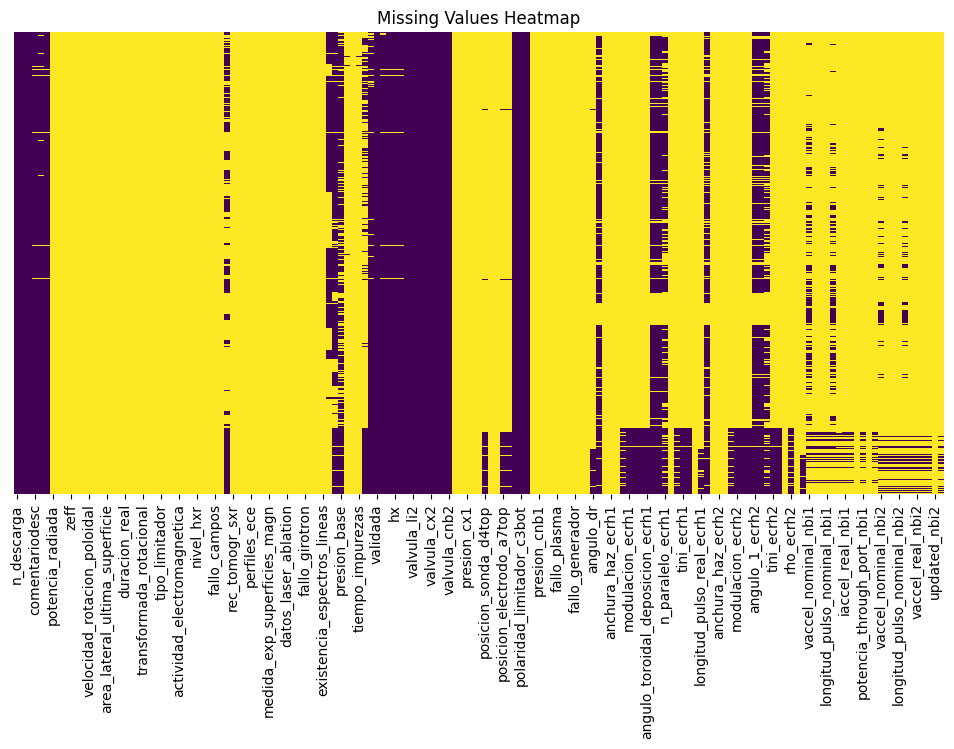

In [23]:
### 2. Visualizing Missing Values (Only If They Exist) ###
plt.figure(figsize=(12, 6))

# Replace empty strings and whitespace-only values with NaN to detect missing values
df.replace(r"^\s*$", np.nan, regex=True, inplace=True)

# Check if there are missing values
if df.isnull().sum().sum() > 0:
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title("Missing Values Heatmap")
    plt.show()
else:
    print("No missing values found in the dataset.")

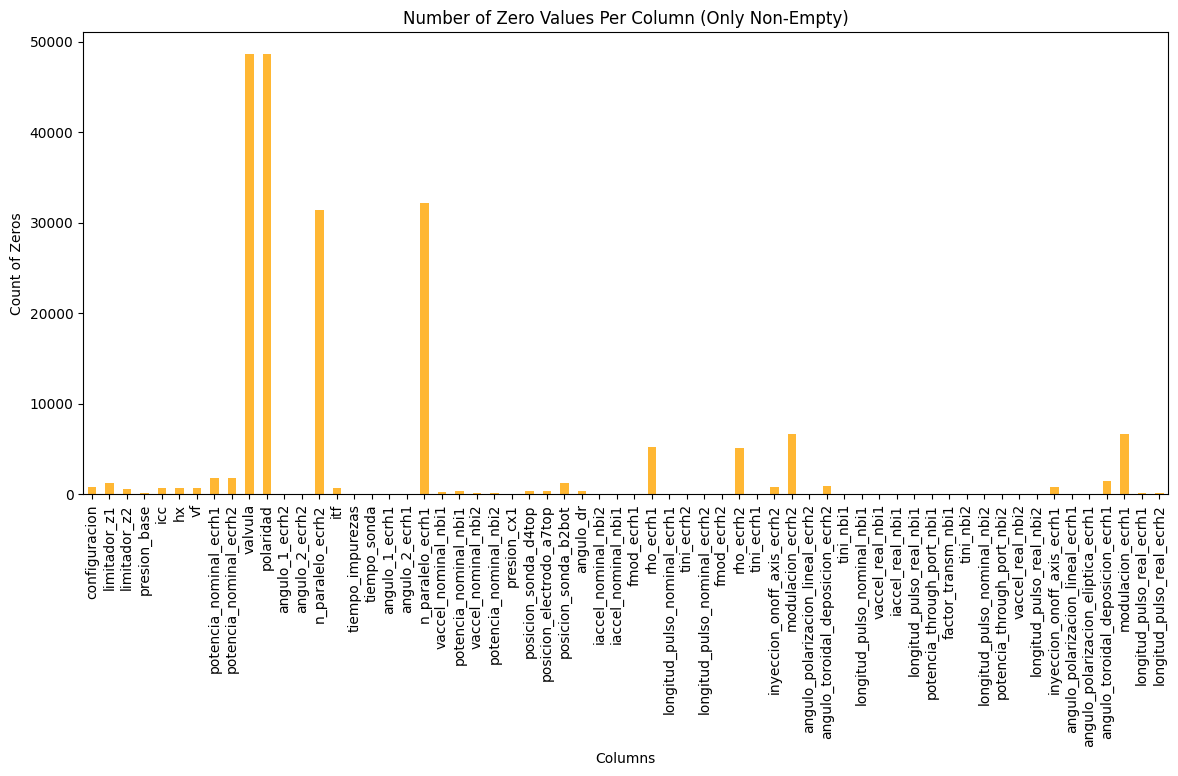

In [21]:
### 3. Visualizing Only Columns with Zero Values ###
zero_values = (df == 0).sum()

# Filter out columns where there are no zero values
zero_values = zero_values[zero_values > 0]

# Plot only columns that have zero values
if not zero_values.empty:
    plt.figure(figsize=(14, 6))
    zero_values.plot(kind="bar", color="orange", alpha=0.8)
    plt.title("Number of Zero Values Per Column (Only Non-Empty)")
    plt.xlabel("Columns")
    plt.ylabel("Count of Zeros")
    plt.xticks(rotation=90)
    plt.show()
else:
    print("No columns contain zero values.")

/var/folders/b6/pb_stfjn0pb7pybgwlqjk5700000gn/T/ipykernel_42025/2198245406.py:6: DtypeWarning: Columns (52,55,58,96,105,108,110,122,125,129,132,133,137,138,143,144,145,150,151,154) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter=';', encoding='latin1')  # Adjust encoding if needed


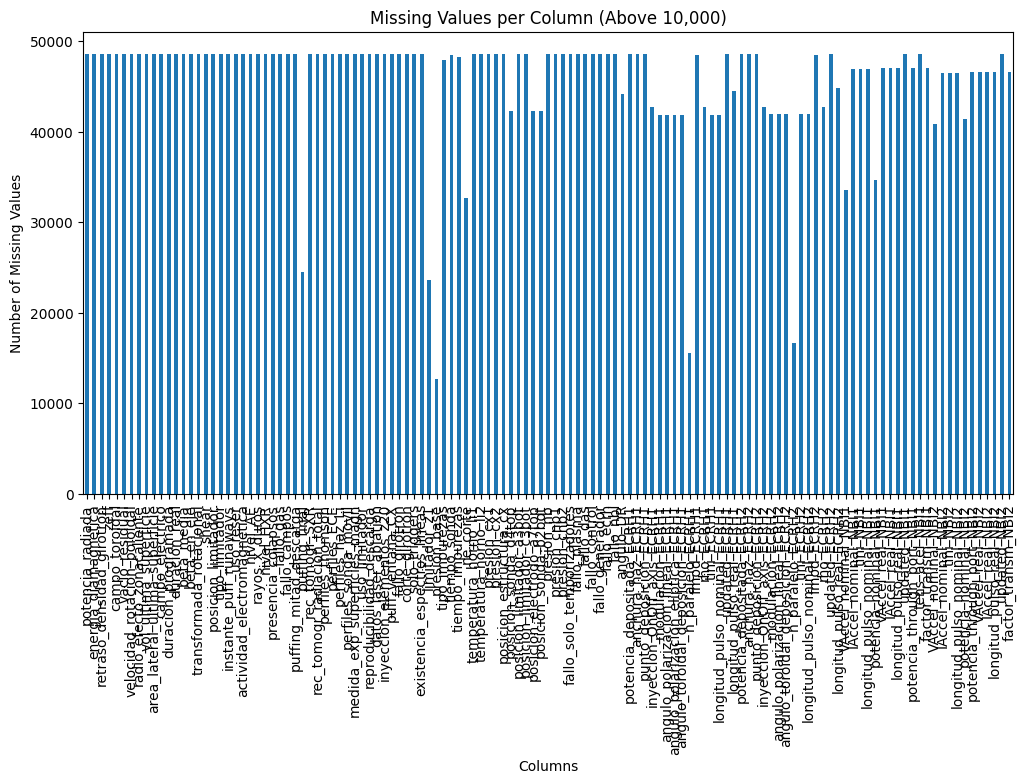

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "data/PARAMETROS_TJ2_ORDENADOS.csv"
df = pd.read_csv(file_path, delimiter=';', encoding='latin1')  # Adjust encoding if needed

# Count missing values per column
missing_values = df.isna().sum()

# Filter out columns with more than 10,000 missing values
missing_values = missing_values[missing_values > 10000]

# Plot the missing values
if not missing_values.empty:
    plt.figure(figsize=(12, 6))
    missing_values.plot(kind='bar')
    plt.xlabel("Columns")
    plt.ylabel("Number of Missing Values")
    plt.title("Missing Values per Column (Above 10,000)")
    plt.xticks(rotation=90)
    plt.show()
else:
    print("No columns have more than 10,000 missing values.")


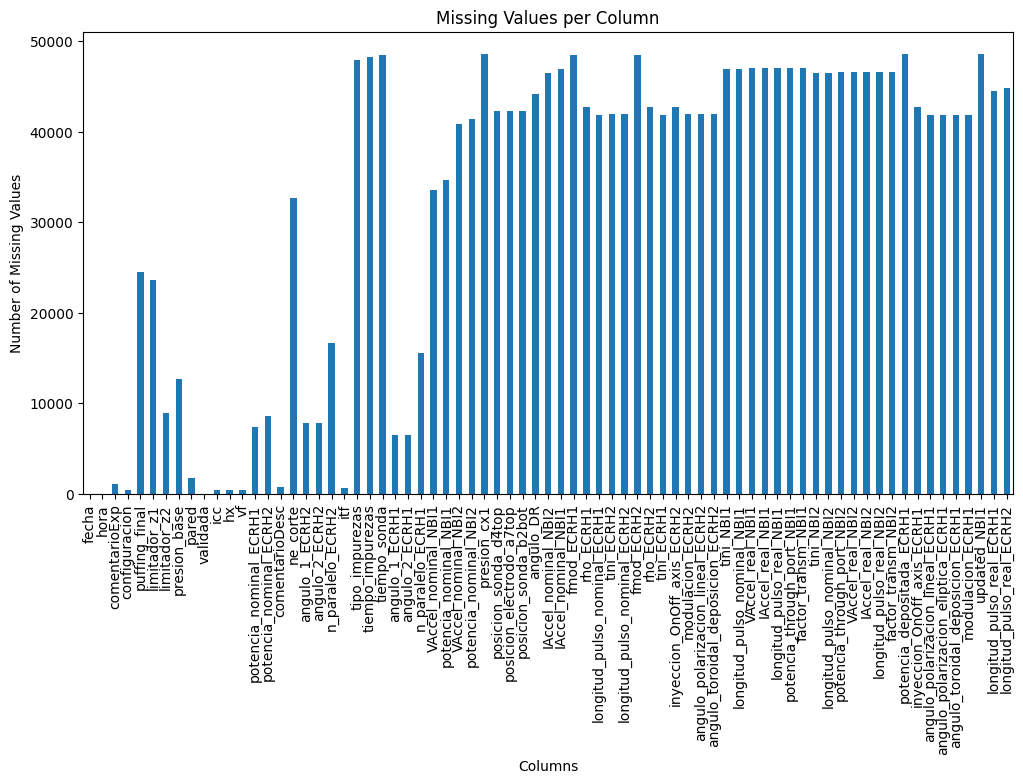

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON file (Modify the path)
file_path = "/Users/sofiamorenolasa/Desktop/TFG/data/PARAMETROS_TJ2_model_time.json"
df = pd.read_json(file_path)

# Count missing values per column
missing_values = df.isna().sum()

# Filter out columns with no missing values
missing_values = missing_values[missing_values > 0]

# Plot the missing values
if not missing_values.empty:
    plt.figure(figsize=(12, 6))
    missing_values.plot(kind='bar')
    plt.xlabel("Columns")
    plt.ylabel("Number of Missing Values")
    plt.title("Missing Values per Column")
    plt.xticks(rotation=90)
    plt.show()
else:
    print("No missing values in the dataset.")

/var/folders/b6/pb_stfjn0pb7pybgwlqjk5700000gn/T/ipykernel_42025/1293237769.py:7: DtypeWarning: Columns (52,55,58,96,105,108,110,122,125,129,132,133,137,138,143,144,145,150,151,154) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter=';', encoding='latin1')  # Adjust encoding if needed


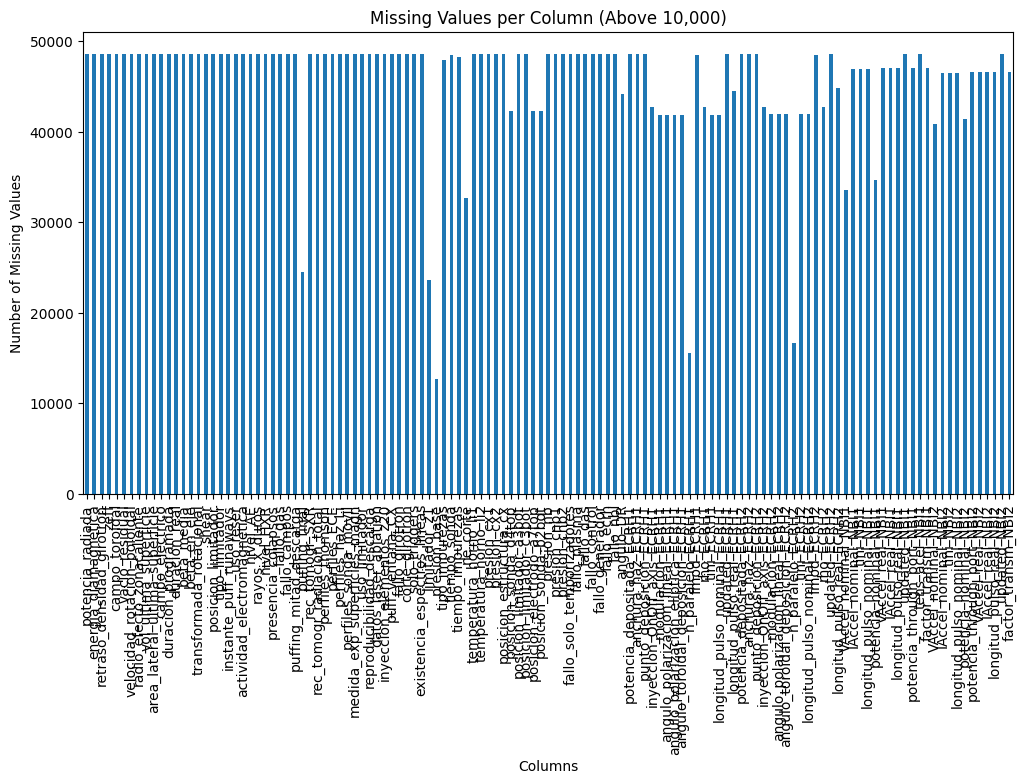

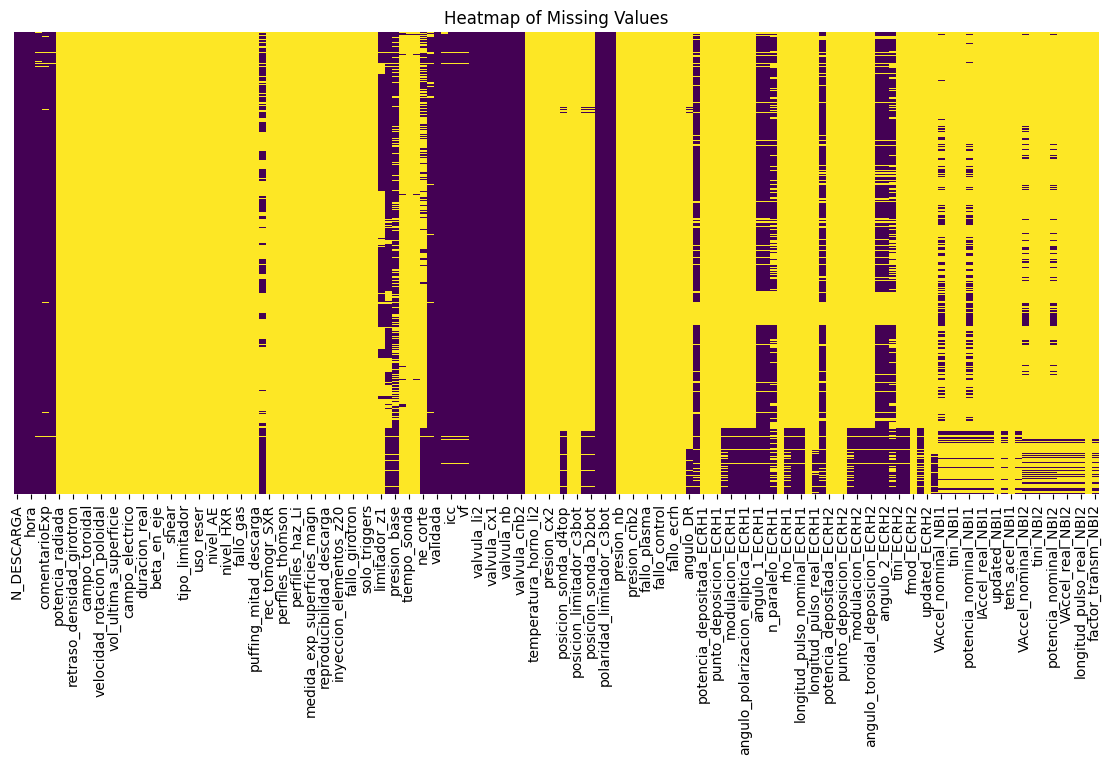

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = "data/PARAMETROS_TJ2_ORDENADOS.csv"
df = pd.read_csv(file_path, delimiter=';', encoding='latin1')  # Adjust encoding if needed

# Count missing values per column
missing_values = df.isna().sum()

# Filter out columns with more than 10,000 missing values
missing_values = missing_values[missing_values > 10000]

# Plot the missing values as a bar chart
if not missing_values.empty:
    plt.figure(figsize=(12, 6))
    missing_values.plot(kind='bar')
    plt.xlabel("Columns")
    plt.ylabel("Number of Missing Values")
    plt.title("Missing Values per Column (Above 10,000)")
    plt.xticks(rotation=90)
    plt.show()
    
    # Heatmap for better visualization
    plt.figure(figsize=(14, 6))
    sns.heatmap(df.isna(), cmap='viridis', cbar=False, yticklabels=False)
    plt.title("Heatmap of Missing Values")
    plt.show()
else:
    print("No columns have more than 10,000 missing values.")

In [31]:
import sqlite3

# Connect to SQLite in-memory database (or replace with your actual database file path)
conn = sqlite3.connect(':memory:')  # Replace with your database file if not using in-memory
cursor = conn.cursor()

# Check the schema of the 'data' table
cursor.execute("PRAGMA table_info(data);")
schema = cursor.fetchall()

print("Table Schema:")
for column in schema:
    print(f"Column ID: {column[0]}, Name: {column[1]}, Type: {column[2]}, Not Null: {column[3]}, Default: {column[4]}, PK: {column[5]}")

# Close the connection
conn.close()

Table Schema:


In [33]:
import sqlite3
import pandas as pd
import json

# Path to your JSON file
file_path = '/Users/sofiamorenolasa/Desktop/TFG/data/PARAMETROS_TJ2_model_time.json'

# Step 1: Load the JSON file into a pandas DataFrame
with open(file_path, 'r', encoding='utf-8') as f:
    raw_json_data = json.load(f)

# Convert JSON to DataFrame
data = pd.DataFrame.from_records(raw_json_data)

# Step 2: Connect to an SQLite database (replace ':memory:' with your actual file path if needed)
conn = sqlite3.connect(':memory:')  # This uses an in-memory database; replace with file path if persistent
cursor = conn.cursor()

# Step 3: Write the DataFrame to SQLite (this creates the 'data' table)
data.to_sql('data', conn, index=False, if_exists='replace')

# Step 4: Verify that the table was created and view the schema
print("Table Schema:")
cursor.execute("PRAGMA table_info(data);")
schema = cursor.fetchall()

# Print the schema (columns) of the 'data' table
for column in schema:
    print(f"Column ID: {column[0]}, Name: {column[1]}, Type: {column[2]}, Not Null: {column[3]}, Default: {column[4]}, PK: {column[5]}")

# Step 5: View the first few rows of the 'data' table to ensure data was loaded correctly
print("\nFirst 5 rows of the 'data' table:")
query = "SELECT * FROM data LIMIT 5"
result = pd.read_sql(query, conn)
print(result)

# Step 6: Close the SQLite connection
conn.close()

Table Schema:
Column ID: 0, Name: N_DESCARGA, Type: TEXT, Not Null: 0, Default: None, PK: 0
Column ID: 1, Name: fecha, Type: TEXT, Not Null: 0, Default: None, PK: 0
Column ID: 2, Name: hora, Type: TEXT, Not Null: 0, Default: None, PK: 0
Column ID: 3, Name: comentarioExp, Type: TEXT, Not Null: 0, Default: None, PK: 0
Column ID: 4, Name: configuracion, Type: TEXT, Not Null: 0, Default: None, PK: 0
Column ID: 5, Name: puffing_final, Type: TEXT, Not Null: 0, Default: None, PK: 0
Column ID: 6, Name: limitador_z1, Type: TEXT, Not Null: 0, Default: None, PK: 0
Column ID: 7, Name: limitador_z2, Type: TEXT, Not Null: 0, Default: None, PK: 0
Column ID: 8, Name: presion_base, Type: TEXT, Not Null: 0, Default: None, PK: 0
Column ID: 9, Name: pared, Type: TEXT, Not Null: 0, Default: None, PK: 0
Column ID: 10, Name: validada, Type: TEXT, Not Null: 0, Default: None, PK: 0
Column ID: 11, Name: icc, Type: TEXT, Not Null: 0, Default: None, PK: 0
Column ID: 12, Name: hx, Type: TEXT, Not Null: 0, Default: